In [1]:
import pandas as pd
import numpy as np
from wordcloud import WordCloud
from nltk.corpus import stopwords 
import matplotlib.pyplot as plt

data_1 = pd.read_csv('/Datasets/Airbnb/listings.csv')
data_1 = data_1.rename(columns = {'id':'listing_id'})
data_2 = pd.read_csv('/Datasets/Airbnb/reviews.csv')
data_all = pd.merge(data_2, data_1, on='listing_id')
data_all['name'] = data_all['name'].astype(str)
data_all['year'] = data_all['date'].apply(lambda x: x[:4]).astype(int)

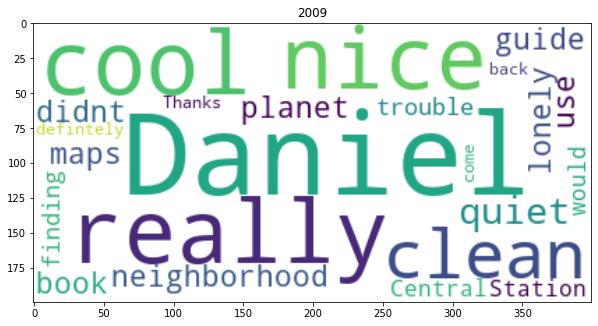

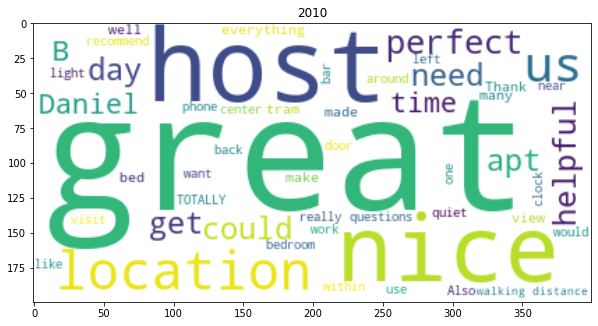

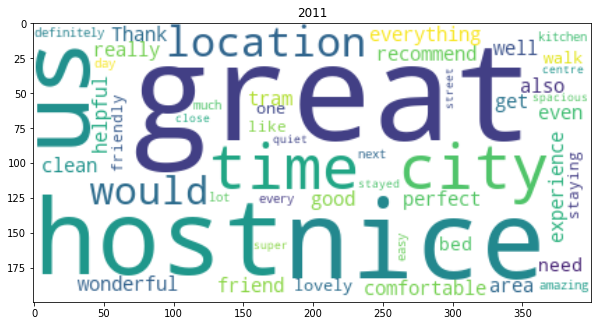

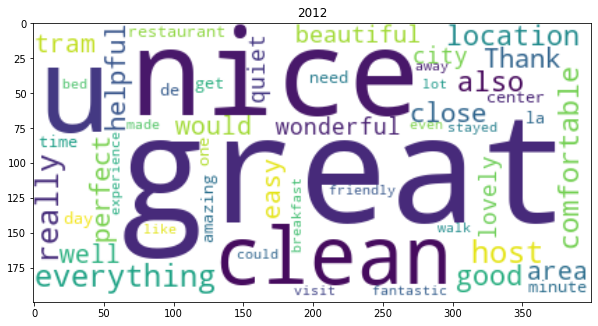

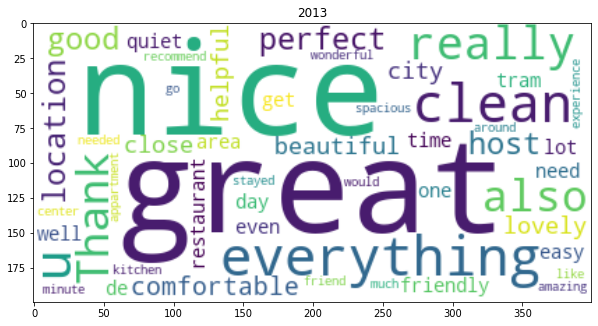

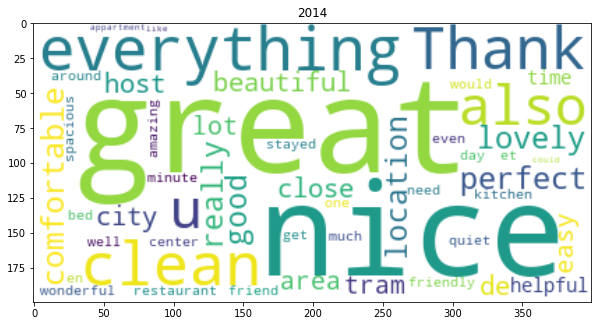

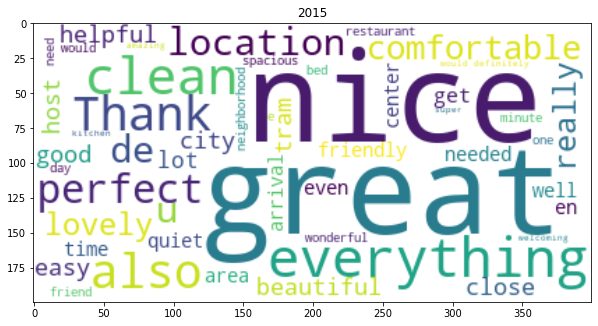

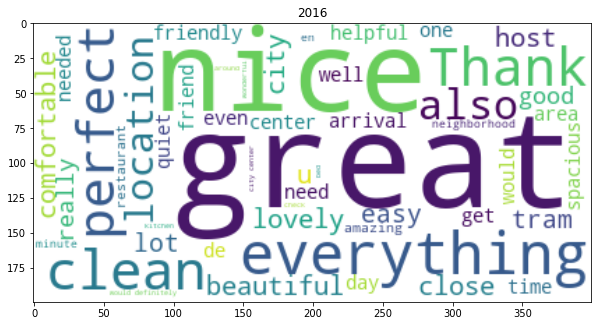

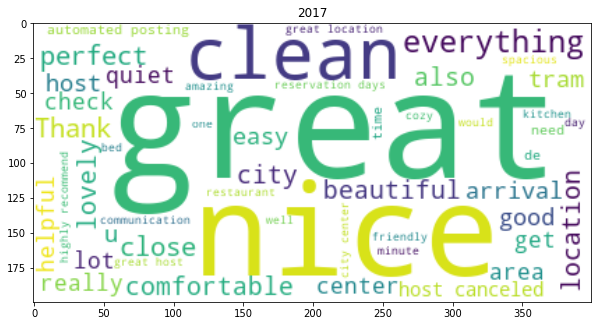

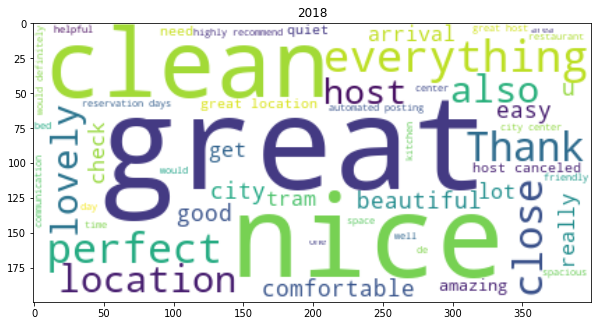

In [2]:
stopwords = stopwords.words('english')
newstops = ['Amsterdam', 'stay', 'place', 'apartment', 'flat', 'room', 'home', 'house']
stopwords.extend(newstops)

wordcloud = WordCloud(background_color='white', max_words=50, stopwords=stopwords)

for year in np.arange(2009, 2019, 1):
    wordcloud.generate(' '.join(data_all[data_all['year'] == year].drop_duplicates(['listing_id'])['comments'].astype(str)))
    plt.figure(figsize=(10, 10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(year)

Text(0, 0.5, 'Frequency')

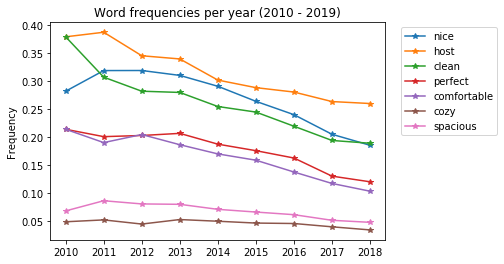

In [3]:
def word_frequencies(word):
    freqs = []
    for year in np.arange(2010, 2019, 1):
        freqs.append(sum([1 for i in data_all[data_all['year'] ==  year]['comments'].astype(str) if word in i])/len(data_all[data_all['year'] ==  year]['comments']))
    return freqs

obtained_freqs = []
for word in ['nice', 'host', 'clean', 'perfect', 'comfortable', 'cozy', 'spacious']:
    obtained_freqs.append(word_frequencies(word))
    
fig = plt.figure()
ax = fig.add_subplot(111)

for i, word in zip(np.arange(0, 7, 1), ['nice', 'host', 'clean', 'perfect', 'comfortable', 'cozy', 'spacious']):
    plt.plot(np.arange(2010, 2019, 1), obtained_freqs[i], marker='*', label=word)
plt.legend(bbox_to_anchor=(1.35, 1), loc='upper right')
plt.title('Word frequencies per year (2010 - 2019)')
plt.ylabel('Frequency')